# <center><font color='orange'> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА </font></center>

## <font color='springgreen'>Цель исследования:</font>
Исследовать данные о зарплатах в сфере Data Science за 2020–2022 годы.

#### Основные задачи от заказчика исследования:
**1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.**\
**2. А также ответить на ключевые вопросы HR-агентства:**
 * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
 * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
 * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
 * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [88]:
# импортируем необходимые библиотеки 
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

#### <font color='green'>**Загружаем данные**</font>

In [89]:
# загружаем данные из cvs-файла и посмотрим на первые 5 строк
data = pd.read_csv('data/ds_salaries.zip', index_col=0)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


**Датасет содержит следующие признаки:**

*   *work_year* — год выплаты зарплаты;
*   *experience_level* — опыт работы на должности Data Science в течение года на следующих позициях:\
         EN — Entry-level/Junior;\
         MI — Mid-level/Intermediate;\
         SE — Senior-level/Expert;\
         EX — Executive-level/Director;
*   *employment_type* — тип трудоустройства:\
         PT — неполный рабочий день;\
         FT — полный рабочий день;\
         CT — контракт;\
         FL — фриланс;
*   *job_title* — роль, в которой соискатель работал в течение года;
*   *salary* — общая выплаченная валовая сумма заработной платы;
*   *salary_currency* — валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *salary_in_usd* — зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com);
*   *employee_residence* - основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* - общий объём работы, выполняемой удалённо. Значения:\
         0 — удалённой работы нет (менее 20 %);\
         50 — частично удалённая работа;\
         100 — полностью удалённая работа (более 80 %);
*   *company_location* - страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
*   *company_size* - среднее количество людей, работавших в компании в течение года:\
         S — менее 50 сотрудников (небольшая компания);\
         M — от 50 до 250 сотрудников (средняя компания);\
         L — более 250 сотрудников (крупная компания).

## <font color='green'>**Описательный анализ данных**</font>

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете представлены 11 признаков в 607 записях (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [91]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))
# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


Как мы видим при обзорном изучении у нас два признака о зарплате: 'salary' - который описывает зарплату в разных валютах и 'salary_in_usd' - в котором зарплата приведена к единой валюте долл.\
Для анализа, конечно, нам необходим признак 'salary_in_usd', преобразованный в единый формат, поэтому удалим признак 'salary' и связанный с ним признак 'salary_currency'.

In [92]:
data.drop(['salary', 'salary_currency'], axis=1, inplace=True)

**Посмотрим на основные статистические метрики датасета по категориальным признакам**

In [93]:
data.describe(include=['object'])

,experience_level,employment_type,job_title,employee_residence,company_location,company_size
count,565,565,565,565,565,565
unique,4,4,50,57,50,3
top,SE,FT,Data Scientist,US,US,M
freq,243,546,130,295,318,290


In [94]:
# категориальный признак 'employment_type' практически имеет одно значение('полный рабочий день' 546 значений из 565), 
# таким образом является неиформативным для исследования, удалим данный признак
data.drop('employment_type', axis=1, inplace=True)

In [95]:
# посмотрим на датасет после преобразования
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   job_title           565 non-null    object
 3   salary_in_usd       565 non-null    int64 
 4   employee_residence  565 non-null    object
 5   remote_ratio        565 non-null    int64 
 6   company_location    565 non-null    object
 7   company_size        565 non-null    object
dtypes: int64(3), object(5)
memory usage: 39.7+ KB


<font color='orange'>**ВЫВОД:**</font>\
В датасете после удаления дубликатов и неиформативных признаков осталось 8 признаков, 565 значений: 
* категориальных порядковых (*experience_level*, *remote_ratio*, *company_size*), 
* категориальных номинальных (*job_title*, *employee_residence*, *company_location*), 
* количественного порядкового (*work_year*), 
* количественного непрерывного (*salary_in_usd*).

Моды категориальных признаков показали нам:
* самый востребованный уровень специалистов Data Science - expert,
* абсолютное большинство специалистов трудоустроены на полный рабочий день,
* самым распространненым типом исполнения работы для специалистов Data Science является удаленная работа,
* большинство бизнеса на рынке представлено компаниями средних размеров.

## <font color='green'>**Детальное изучение признаков и их взаимосвязей**</font>

### 1. Распределение нашего ключевого признака - заработная плата *salary_in_usd*

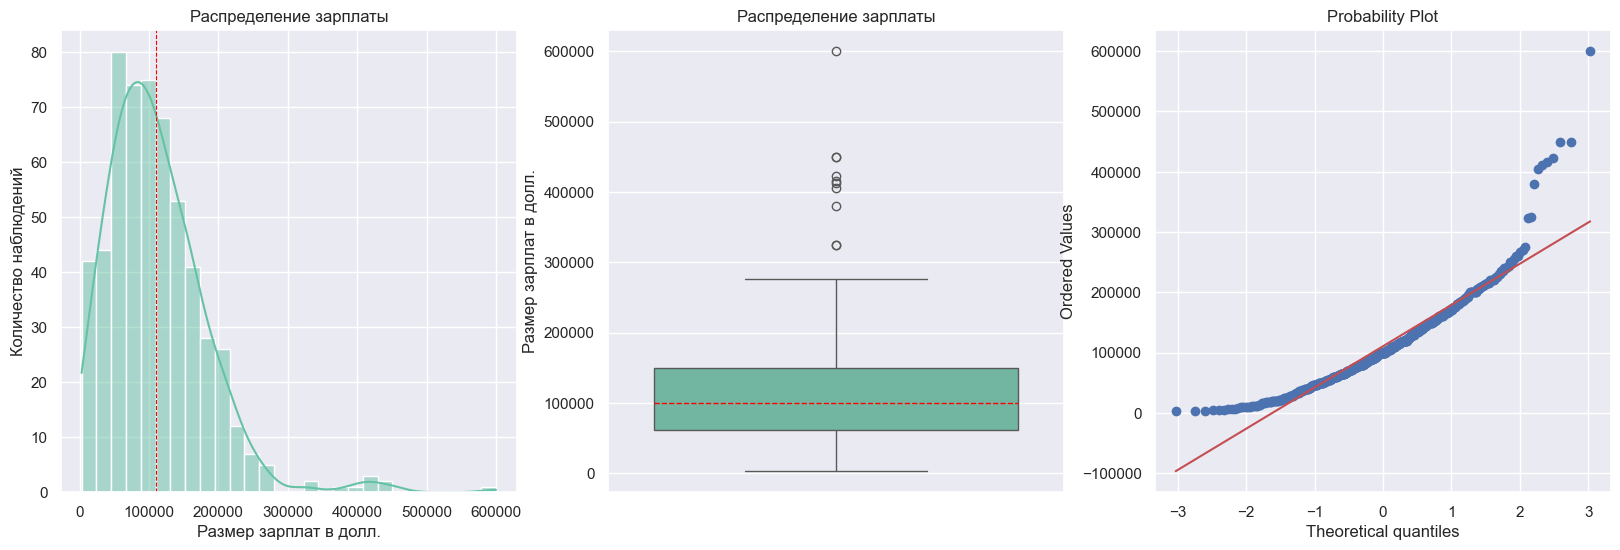

In [96]:
# отобразим данный признак на графиках
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# гистограмма
sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0]) # добавим отображение графика плотности ядра kde
axes[0].set(xlabel='Размер зарплат в долл.', ylabel='Количество наблюдений')
axes[0].set_title('Распределение зарплаты')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8) # отобразим среднее значение
# коробчатая диаграмма
sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='v', medianprops={"color": "red", "linestyle": '--'}) # отобразим медиану
axes[1].set(ylabel='Размер зарплат в долл.')
axes[1].set_title('Распределение зарплаты')
# график qq-plot
stats.probplot(data['salary_in_usd'],plot=plt)
plt.show()

In [97]:
# посмотрим на статистические метрики
data_salary = data['salary_in_usd'].describe().round(2).to_frame()
data_salary.columns = ['Статистика по зарплатам']
data_salary

,Статистика по зарплатам
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


<font color='orange'>**ВЫВОД:**</font>\
Распределение признака "заработная плата" отлично от нормального, имеются выбросы и очень большой выброс в 600000$.\
Отметим, что медиана и среднее арифметическое не сильно различны: 100 и 110 тыс.$.

### 2. Изменение зарплаты во времени.
**Признак **work_year** представлен тремя годами 2020, 2021, 2022.**

In [98]:
data['work_year'].unique()

array([2020, 2021, 2022], dtype=int64)

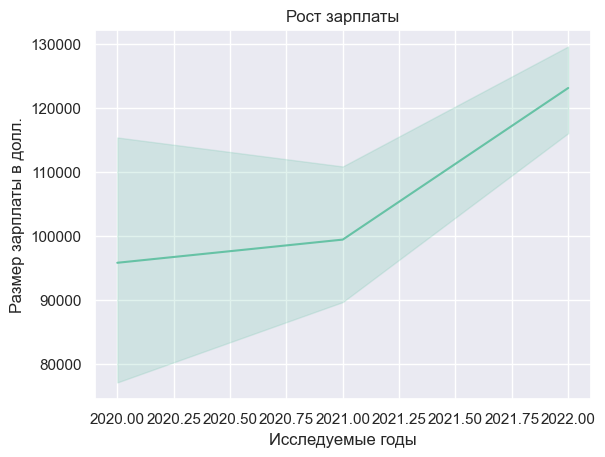

In [99]:
# линейный график роста зарплаты во времени
line = sns.lineplot(data, x='work_year', y='salary_in_usd')
line.set(xlabel='Исследуемые годы', ylabel='Размер зарплаты в долл.')
plt.title('Рост зарплаты')
plt.show()

<font color='orange'>**ВЫВОД:**</font>\
Наблюдаем активный рост зарплат в сфере Data Science с 2021 года.

### 3. Размер зарплаты в зависимости от профессионального уровня специалиста Data Science

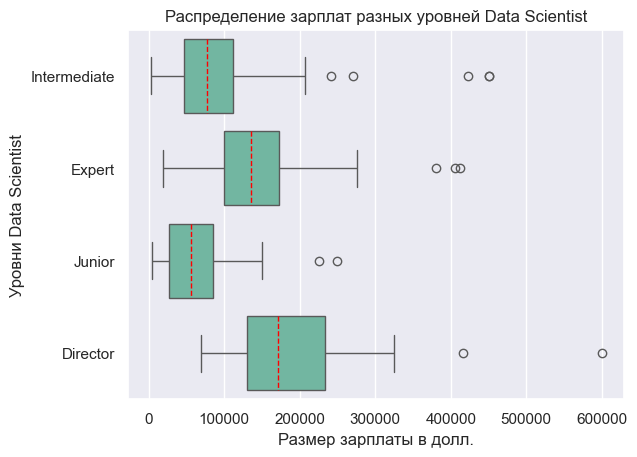

In [100]:
# с помощью метода replace заменим сокращенные обозначения уровней Data Scientist на полные
data['experience_level'] = data['experience_level'].replace(['EN', 'MI', 'SE', 'EX'], ['Junior', 'Intermediate', 'Expert', 'Director'])
# построим коробчатую диаграмму
boxplot = sns.boxplot(data, y='experience_level', x='salary_in_usd', orient='h', medianprops={"color": "red", "linestyle": '--'})
boxplot.set(xlabel='Размер зарплаты в долл.', ylabel='Уровни Data Scientist')
plt.title('Распределение зарплат разных уровней Data Scientist')
plt.show()

In [101]:
# статистические метрики взаимосвязи двух признаков
data_level = data.groupby('experience_level')['salary_in_usd'].describe().round()
print('Размер зарплаты разных профессиональных уровней Data Sciencist')
data_level

Размер зарплаты разных профессиональных уровней Data Sciencist


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
Director,26.0,199392.0,117071.0,69741.0,130006.0,171438.0,233750.0,600000.0
Expert,243.0,138375.0,59956.0,18907.0,99532.0,135000.0,171881.0,412000.0
Intermediate,208.0,87793.0,64119.0,2859.0,47164.0,76940.0,112075.0,450000.0
Junior,88.0,61643.0,44396.0,4000.0,27505.0,56500.0,85426.0,250000.0


<font color='orange'>**ВЫВОД:**</font>\
Разница в размере зарплаты между различными профессиональными уровнями Data Scientist отражает статус этих уровней: от начального - Junior до руководителя - Director.\
Соответственно с повышением профессионального уровня увеличивается заработная плата и стоит отметить и увеличение размаха и выбросов.

### 4. Самые популярные направления специалистов Data Science (признак *job_title*) и их медианная зарплата.

In [102]:
print('Самые популярные направления Data Science:')
display(data['job_title'].value_counts().head())
# создаем список самых популярных должностей
top_title = ['Data Scientist', 'Data Engineer', 'Data Analyst', 'Machine Learning Engineer']
# заменим все должности, которые составляют менее 5% в данных на 'other'
# через метод apply применим lambda-функцию, если должность есть в списке популярных, то она сохраняется, если нет - заменяется на категорию 'other'
data['job_title'] = data['job_title'].apply(lambda x: x if x in top_title else 'other') 

Самые популярные направления Data Science:


job_title
Data Scientist               130
Data Engineer                121
Data Analyst                  82
Machine Learning Engineer     39
Research Scientist            16
Name: count, dtype: int64

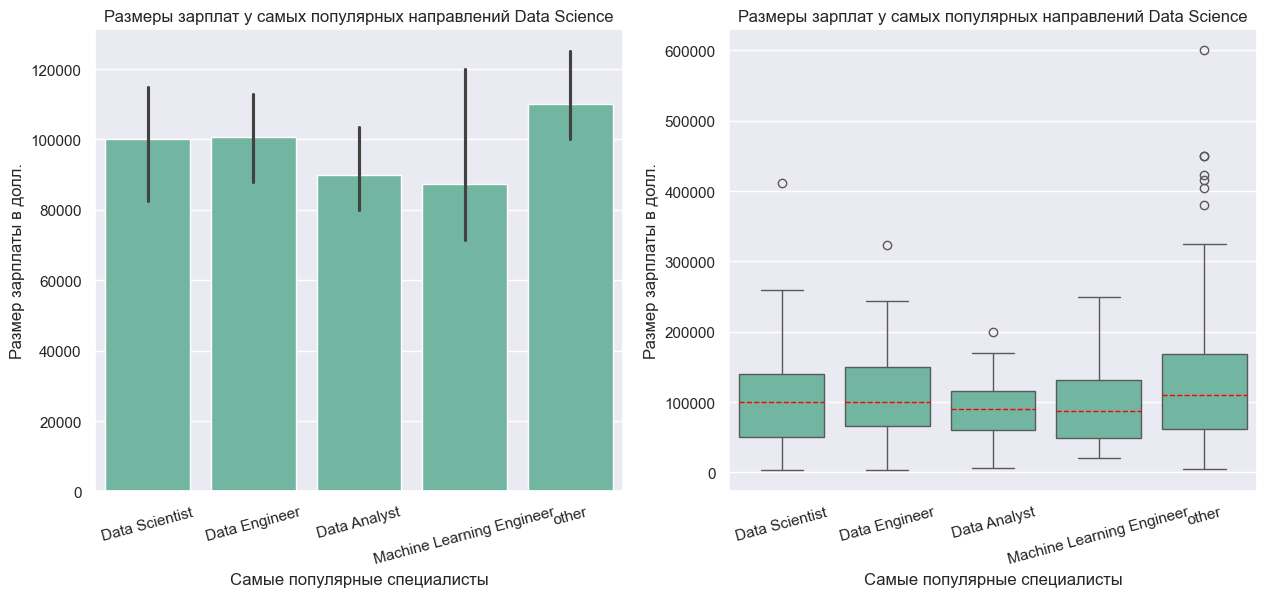

In [103]:
# отобразим медианную зарплату у самых популярных направлений Data Science
fig, ax = plt.subplots(1, 2, figsize=(15,6))
# столбчатая диаграмма
ax[0] = sns.barplot(data, x='job_title', y='salary_in_usd', orient='v', estimator='median',         # агрегируем по медиане
                    order=["Data Scientist", "Data Engineer", "Data Analyst", "Machine Learning Engineer", 'other'], ax=ax[0])
ax[0].set(xlabel='Самые популярные специалисты', ylabel='Размер зарплаты в долл.')
ax[0].xaxis.set_tick_params(rotation=15)
ax[0].set_title('Размеры зарплат у самых популярных направлений Data Science')
# коробчатая диаграмма
sns.boxplot(data, x='job_title', y='salary_in_usd', orient='v', ax=ax[1], medianprops={"color": "red", "linestyle": '--'},
            order=["Data Scientist", "Data Engineer", "Data Analyst", "Machine Learning Engineer", 'other'])
ax[1].set(xlabel='Самые популярные специалисты', ylabel='Размер зарплаты в долл.')
ax[1].xaxis.set_tick_params(rotation=15)
ax[1].set_title('Размеры зарплат у самых популярных направлений Data Science')
plt.show()

In [104]:
# статистические показатели по зарплатам у разных специалистов Data Science
data_title = data.groupby('job_title')['salary_in_usd'].describe().round()
print('Размеры зарплат у самых популярных направлений Data Science')
data_title

Размеры зарплат у самых популярных направлений Data Science


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Analyst,82.0,90090.0,40686.0,6072.0,60325.0,90000.0,116112.0,200000.0
Data Engineer,121.0,109750.0,58204.0,4000.0,66022.0,100800.0,150000.0,324000.0
Data Scientist,130.0,103336.0,63968.0,2859.0,50330.0,100000.0,140400.0,412000.0
Machine Learning Engineer,39.0,101165.0,62519.0,20000.0,49173.0,87425.0,131500.0,250000.0
other,193.0,126677.0,92276.0,5409.0,61896.0,110000.0,168000.0,600000.0


<font color='orange'>**ВЫВОД:**</font>\
Медианы зарплат двух самых популярных направлений Data Science: Data Scientist и Data Engineer показывают нам, что они практически одинаковы, несмотря на то, что среднее значение зарплаты Data Engineer выше, мы помним про выбросы, которые очень влияют на среднее арифметическое, и будем ориентироваться на медиану.\
Стоить отметить разницу в размахах в зарплате у Data Engineer - 66-150 тыс.долл., у Data Scientist - 50-140 тыс.долл., то есть с среднем Data Engineer возможно зарабатывает немного больше специалиста Data Scientist.

### 5. А теперь анализ самых популярных направлений Data Science и их медианной зарплаты во времени.

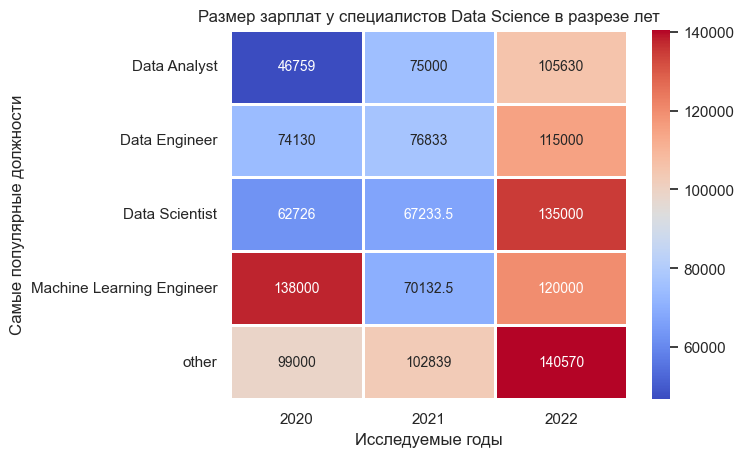

In [105]:
# сводная таблица трех признаков(направлении 'job_title', годы 'work_year', зарплата 'salary_in_usd'), агрегация по медиане признака "зарплата"
pivot = data.pivot_table(values='salary_in_usd', columns='work_year', index='job_title', aggfunc='median')
# отобразим таблицу на тепловой карте
heatmap = sns.heatmap(data=pivot, cmap = 'coolwarm', annot=True, fmt='g', annot_kws = {'fontsize': 10}, linewidths=.9 )
heatmap.set_title('Размер зарплат у специалистов Data Science в разрезе лет')
heatmap.set(ylabel='Самые популярные должности', xlabel='Исследуемые годы');

Создадим таблицу сопряженности признаков направления специалистов Data Science ('job_title') и года ('work_year'), чтобы посмотреть, на каком количестве данных сделаны расчеты медианной зарплаты, чтобы быть уверенным в достоверности расчетов и изучить рост числа специалистов с годами.

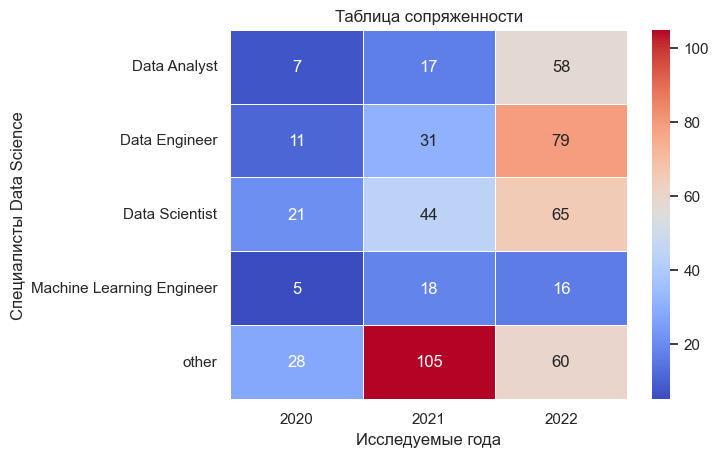

In [106]:
cross_tab = pd.crosstab(index=data['job_title'], columns=data['work_year'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='g', cmap="coolwarm")
ax.set(ylabel='Специалисты Data Science', xlabel='Исследуемые года')
ax.set_title('Таблица сопряженности')
plt.show()

<font color='orange'>**ВЫВОД:**</font>\
Во-первых, мы видим разительную разницу в зарплатах во времени: в 2022 году зарплата Data Engineer на 50% выше по сравнению с предыдущим годом, а зарплата Data Scientist - на 100%.\
Однозначный вывод о высоком росте зарплат специалистов Data Science за последний год.\
Также мы видим увеличение числа специалистов с годами, что говорит о росте востребованности данных специалистов на рынке труда.

### 6. ТОП-10 стран главного офиса работодателя или филиала по контракту (*company_location*) и ТОП-10 стран проживания сотрудника в течение рабочего года (*employee_residence*).

'ТОП-10 стран главного офиса работодателя:'

company_location
US    318
GB     46
CA     28
DE     27
IN     24
FR     15
ES     14
GR     10
JP      6
NL      4
Name: count, dtype: int64

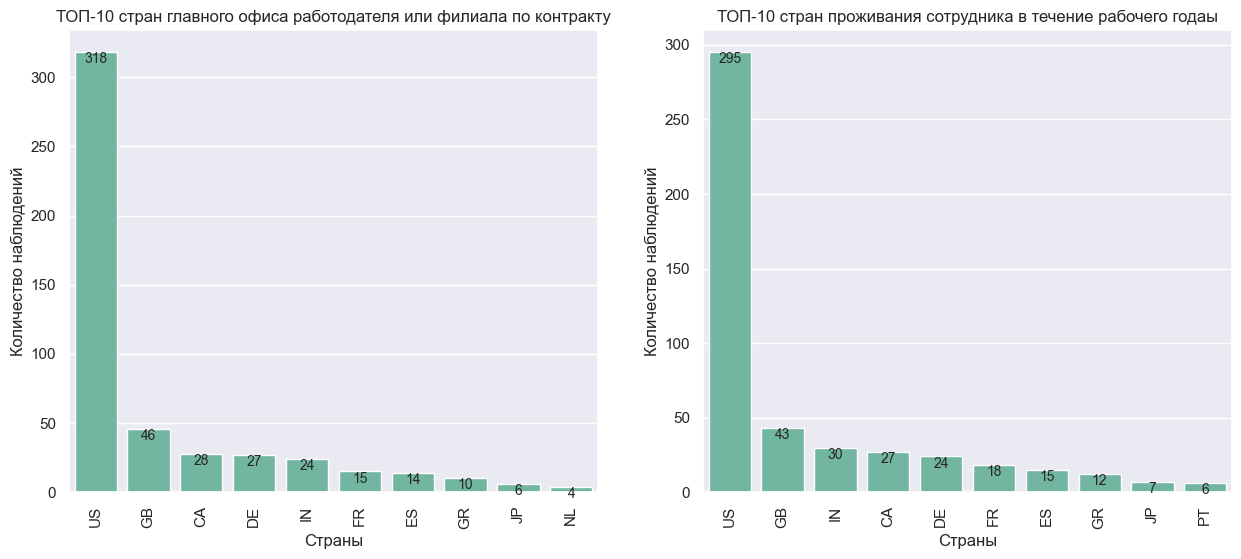

In [107]:
# отсотрируем ТОП-10 стран главного офиса работадателя, метод value_counts() для подсчета количества уникальных значений
data_location = data['company_location'].value_counts().iloc[:10]
display('ТОП-10 стран главного офиса работодателя:', data_location)
# заменим сокращения на полные названия стран, метод replace
data['company_location'] = data['company_location']. replace(['US', 'GB', 'CA', 'DE', 'IN', 'FR', 'ES', 'GR', 'JP', 'NL'],
                            ['США', "Великобритания", "Канада", "Германия", "Индия", "Франция", "Испания", "Греция", "Япония", "Нидерланды"])

# отсотрируем ТОП-10 стран проживания сотрудника, тот же метод value_counts()
data_residence = data['employee_residence'].value_counts().iloc[:10]
# заменим сокращения на полные названия стран, метод replace
data['employee_residence'] = data['employee_residence']. replace(['US', 'GB', 'IN', 'CA', 'DE', 'FR', 'ES', 'GR', 'JP', 'PT'],
                            ['США', "Великобритания", "Индия", "Канада", "Германия", "Франция", "Испания", "Греция", "Япония", "Португалия"])

# отобразим распределения на столбчатых диаграммах
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0] = sns.barplot(data_location, ax=ax[0])
ax[0].set(ylabel='Количество наблюдений', xlabel='Страны')
for i, country in enumerate(data_location):
    ax[0].text(i, country, country, va='top', horizontalalignment='center', fontsize=10)
ax[0].xaxis.set_tick_params(rotation=90)
ax[0].set_title('ТОП-10 стран главного офиса работодателя или филиала по контракту')

sns.barplot(data_residence, ax=ax[1])
ax[1].set(ylabel='Количество наблюдений', xlabel='Страны')
for i, country in enumerate(data_residence):
    ax[1].text(i, country, country, va='top', horizontalalignment='center', fontsize=10)
ax[1].xaxis.set_tick_params(rotation=90)
ax[1].set_title('ТОП-10 стран проживания сотрудника в течение рабочего годаы')
plt.show()

<font color='orange'>**ВЫВОД:**</font>\
Мы не будем более детально его анализировать на данном этапе исследования, так как для ответов на основные вопросы заказчика он нам не понадобиться.\
Мы помним, что в исследуемом датасете 565 строк после удаления дубликатов, по графикам сразу видно, что абсолютным лидером среди востребованности в специалистах Data Science является США, дальше по убывнию примерно одинаково и похожий состав в обоих графиках.\
Можно сделать вывод, что в основном Data Scientists работают в своих же странах, но учитывая удаленную возможность сотрудничества, то Data Scientist может проживать в одной стане и работать за рубежом, например, Индия: 30 специалистов проживают здесь, хотя 24 компании имеют сотрудников Data Science.

### 7. Распределение и взаимосвязь признака способ исполнения работы (*remote_ratio*) и зарплаты. 

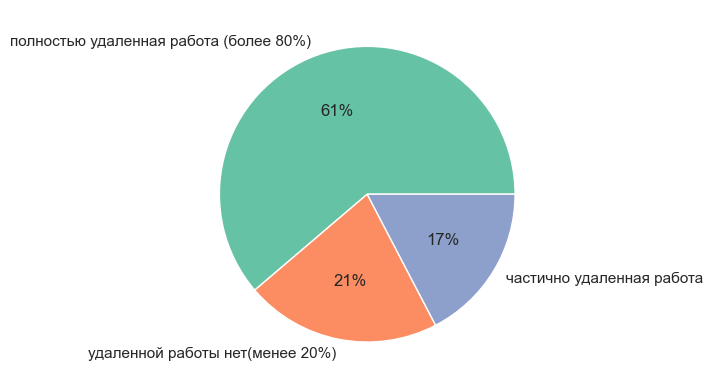

In [108]:
# переведем количественный показатель признака в категориальное описание, метод replace
data['remote_ratio'] = data['remote_ratio'].replace(
    {0: 'удаленной работы нет(менее 20%)', 50: 'частично удаленная работа', 100: 'полностью удаленная работа (более 80%)'})
data_remote = data['remote_ratio'].value_counts()
# отобразим соотношение между видами удаленности в работе на круговой диаграмме
plt.pie(data_remote, labels = data_remote.index, autopct = '%.0f%%')
plt.show()

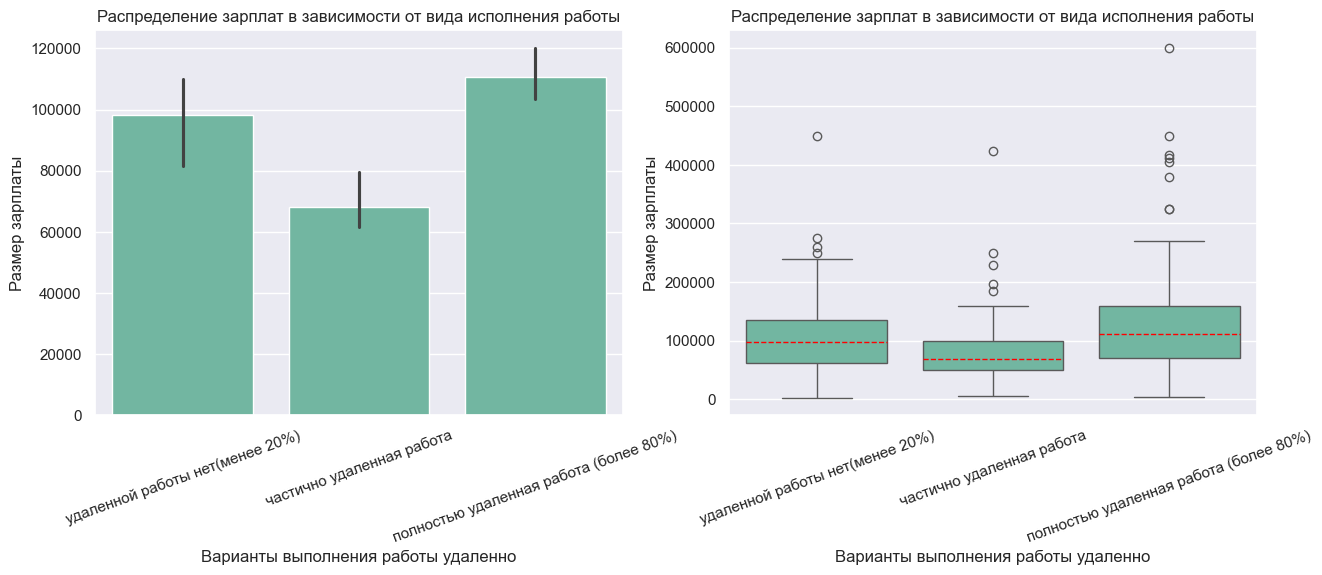

In [109]:
# отобразим на графике, как распределяется зарплата в зависимости от вида исполнения работы по показателю удаленности
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# столбчатая диаграмма
ax[0] = sns.barplot(data, x='remote_ratio', y='salary_in_usd', orient='v', estimator='median', ax=ax[0])
ax[0].set(xlabel='Варианты выполнения работы удаленно', ylabel='Размер зарплаты')
ax[0].xaxis.set_tick_params(rotation=20)
ax[0].set_title('Распределение зарплат в зависимости от вида исполнения работы')
# коробчатая диаграмма
sns.boxplot(data, x='remote_ratio', y='salary_in_usd', orient='v', ax=ax[1], medianprops={"color": "red", "linestyle": '--'})
ax[1].set(xlabel='Варианты выполнения работы удаленно', ylabel='Размер зарплаты')
ax[1].xaxis.set_tick_params(rotation=20)
ax[1].set_title('Распределение зарплат в зависимости от вида исполнения работы')
plt.show()

<font color='orange'>**ВЫВОД:**</font>\
Самое главное, что стоит отметить , что профессии в сфере Data Science относятся к IT и могут исполняться удаленно, что мы и видим на круговой диаграмме, в основном исполнение происходит удаленно, и это большой плюс, на первый план выходит эффективность исполнения, взаимодействие команды спелиалистов в данном направлении, а не часы и присутствие в офисе.\
Нужно понимать, что эффективность исполнения большей части обязанностей специалиста данной профессии зависит от следующих факторов: комфортное место, свой график дисциплины и высокая оценка труда в денежном эквиваленте. \
Самая высокая медианная зарплата и б`ольший размах в зарплате наблюдается у специалистов, исполняющих работу полностью удаленно.

### 8. Распределение и взаимосвязь признака размера компании (*company_size*) и зарплаты, а также соотношение ключевых специалистов Data Science в разных компаниях.

Количество компаний разных размеров в датасете


company_size
средняя (50-250 сотрудников)        290
крупная (более 250 сотрудников)     193
небольшая (менее 50 сотрудников)     82
Name: count, dtype: int64

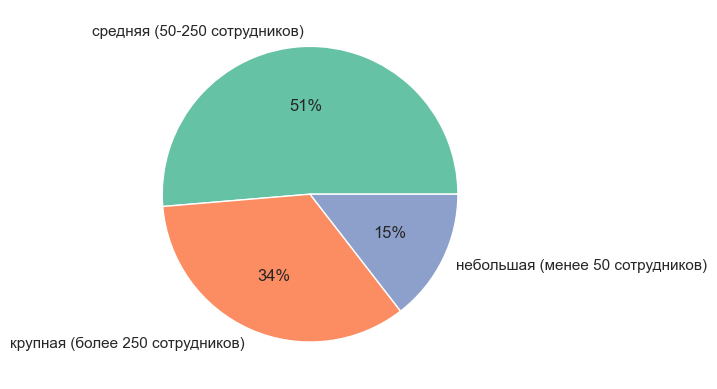

In [110]:
# преобразуем обозначения в признаке в более детальное описание, метод replace
data['company_size'] = data['company_size'].replace(
    {'S': 'небольшая (менее 50 сотрудников)', 'M': 'средняя (50-250 сотрудников)', 'L': 'крупная (более 250 сотрудников)'})
data_company = data['company_size'].value_counts()
print('Количество компаний разных размеров в датасете')
display(data_company)
# отобразим соотношение наличия разных размеров компаний на круговой диаграмме
plt.pie(data_company, labels = data_company.index, autopct = '%.0f%%')
plt.show()

**Какова медианная зарплата в разного размера компаниях?**

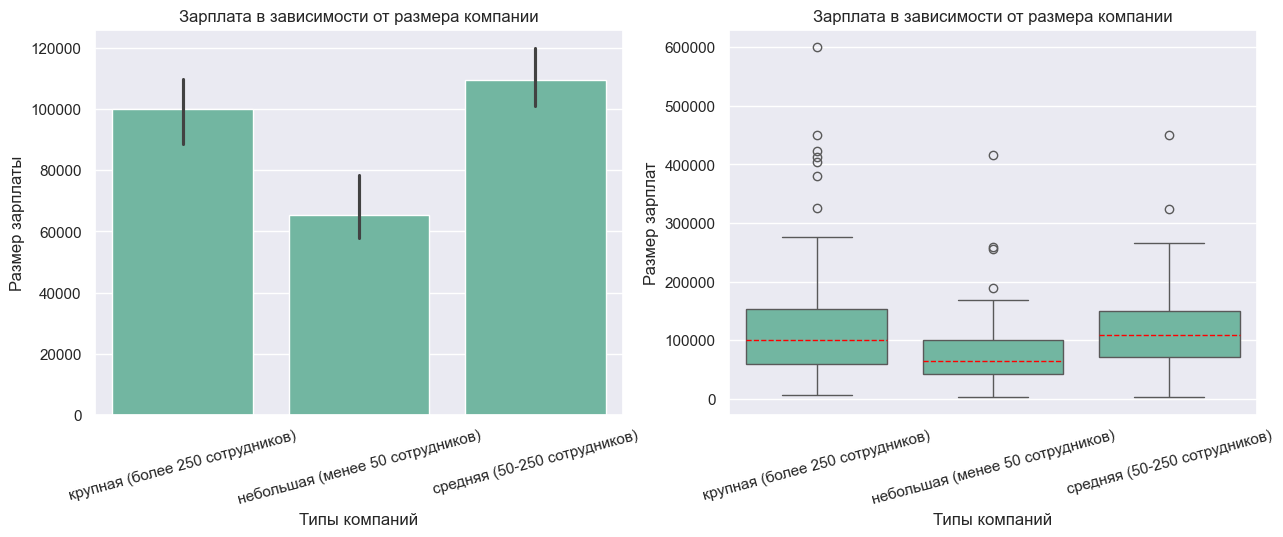

In [111]:
# отобразим медианную зарплату в разного размера компаниях
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# столбчатая диаграмма
ax[0] = sns.barplot(data, x='company_size', y='salary_in_usd', orient='v', estimator='median', ax=ax[0])
ax[0].set(xlabel='Типы компаний', ylabel='Размер зарплаты')
ax[0].xaxis.set_tick_params(rotation=15)
ax[0].set_title('Зарплата в зависимости от размера компании')
# коробчатая диаграмма
sns.boxplot(data, x='company_size', y='salary_in_usd', orient='v', ax=ax[1], medianprops={"color": "red", "linestyle": '--'})
ax[1].set(xlabel='Типы компаний', ylabel='Размер зарплат')
ax[1].xaxis.set_tick_params(rotation=15)
ax[1].set_title('Зарплата в зависимости от размера компании')
plt.show()

In [112]:
# статистические показатели сгруппированных признаков: размера компании и зарплаты
data_company_salary = data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Размеры зарплат в компаниях разных размеров')
data_company_salary

Размеры зарплат в компаниях разных размеров


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
крупная (более 250 сотрудников),193.0,118213.88,86753.27,5882.0,60000.0,100000.0,153667.00,600000.0
небольшая (менее 50 сотрудников),82.0,77872.10,63814.52,2859.0,41816.0,65511.0,100000.00,416000.0
средняя (50-250 сотрудников),290.0,114807.08,60779.04,4000.0,70821.5,109640.0,150213.75,450000.0


**Посмотрим на соотношение самых популярных специалистов Data Science в разного размера компаниях.**

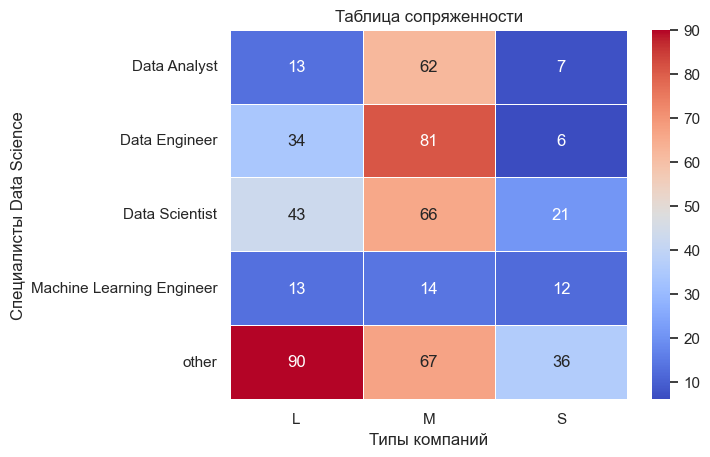

In [113]:
data['company_size'] = data['company_size'].replace(
    {'небольшая (менее 50 сотрудников)': 'S', 'средняя (50-250 сотрудников)': 'M', 'крупная (более 250 сотрудников)': 'L'})
# отобразим количество специалистов в разных компаниях в таблице сопряженности
cross_tab = pd.crosstab(index=data['job_title'], columns=data['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='g', cmap="coolwarm")
ax.set(xlabel='Типы компаний', ylabel='Специалисты Data Science')
ax.set_title('Таблица сопряженности')
plt.show()

**Посмотрим на медианную зарплату самых популярных специалистов Data Science в разного размера компаниях.**

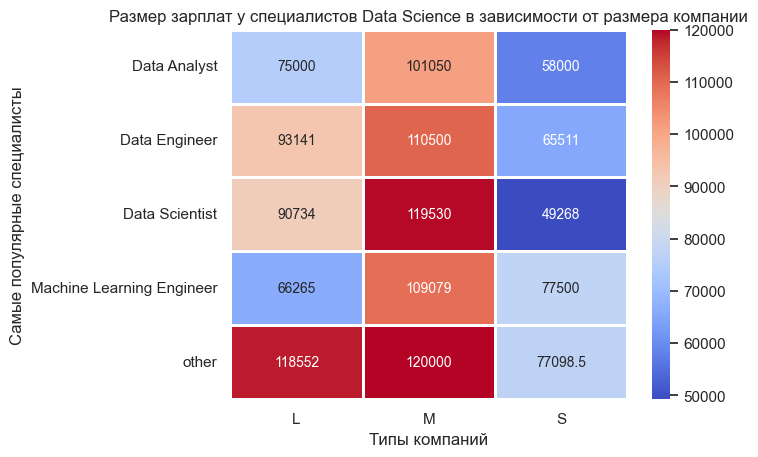

In [114]:
# создадим сводную таблицу рассматриваемых признаков, агрегирующим значением будет медианная зарплата
pivot = data.pivot_table(values='salary_in_usd', columns='company_size', index='job_title', aggfunc='median')
# отобразим полученную таблицу на тепловой карте
heatmap = sns.heatmap(data=pivot, cmap = 'coolwarm', annot=True, fmt='g', annot_kws = {'fontsize': 10}, linewidths=.9 )
heatmap.set_title('Размер зарплат у специалистов Data Science в зависимости от размера компании')
heatmap.set(ylabel='Самые популярные специалисты', xlabel='Типы компаний');

<font color='orange'>**ВЫВОД:**</font>\
Самым распространенным размером компании является компания средних размеров: 50-250 сотрудников.\
Мы наблюдаем наибольшее количество специалистов Data Science в среднего размера компаниях, но это объяснимо, т.к. 51% по количеству в датасете занимают компании среднего размера, но можно изучить это более детально, возможно именно такие компании чаще всего заинтересованы в специалистах Data Science.\
Специалисты Data Science получают лучшую зарплату именно в среднего размера компаниях.

## <font color='green'>**Статистический анализ данных**</font>

Для всех исследований обозначим уровень значимости $\alpha=0.05$.

In [115]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


**Для проведения тестов нам понадобяться критерии определения нормальности и принятия/отклонения гипотез.**\
Напишем для них функции

In [116]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### 1. Статистический тест, определяющий, есть ли рост зарплат с каждым годом?

**Сравнение произведем попарно 2020-2021, 2021-2022**\
**1. Сформулируем нулевую и альтернативную гипотезы первой пары**

*Нулевая гипотеза* ($H_0$): размер заплат в 2020 ($μ_1$) статистически равен или больше размера зарплат в 2021 ($μ_2$).

$$ H_0 : μ_1 >= μ_2 $$

*Альтернативная гипотеза* ($H_1$): размер заплат в 2020 ($μ_1$) статистически меньше размера зарплат в 2021 ($μ_2$).

$$ H_1 : μ_1 < μ_2 $$

**2. Сформулируем нулевую и альтернативную гипотезы второй пары**

*Нулевая гипотеза* ($H_0$): размер заплат в 2021 ($μ_2$) статистически равен или больше размера зарплат в 2022 ($μ_3$).

$$ H_0 : μ_2 >= μ_3 $$

*Альтернативная гипотеза* ($H_1$): размер заплат в 2021 ($μ_2$) статистически меньше размера зарплат в 2022 ($μ_3$).

$$ H_1 : μ_2 < μ_3 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка заключается в следующем:

*Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [117]:
# таблицы зарплат по годам
salary_2020 = data.loc[data['work_year']==2020, 'salary_in_usd']
salary_2021 = data.loc[data['work_year']==2021, 'salary_in_usd']
salary_2022 = data.loc[data['work_year']==2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Зарплата в 2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('Зарплата в 2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Зарплата в 2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])


Зарплата в 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Зарплата в 2021:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Зарплата в 2022:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящие статистические тесты для пар сравнения**

Для выбора нужного теста воспользуемся следующим алгоритмом:
* Какой тип у признака «Зарплата»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет. Для зависимости мы обязаны замерять зарплаты одних и тех же сотрудников каждый год.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить наши гипотезы, можно использовать U-критерий Манна-Уитни для оценки различий распределения признака в двух независимых группах.

**Проведём тесты**

In [118]:
# 2020-2021
_, p1 = stats.mannwhitneyu(salary_2020, salary_2021, alternative='less')
decision_hypothesis(p1)
print()
# 2021-2022
_, p2 = stats.mannwhitneyu(salary_2021, salary_2022, alternative='less')
decision_hypothesis(p2)

p-value = 0.249
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


<font color='orange'>**Вывод**</font>\
Между 2020 и 2021 годом нет статистической разницы в зарплатах, роста не наблюдается.\
Скачок роста зарплат мы наблюдали ранее на графиках в 2022 году и проведенный тест подтвердил исследование, итак мы отвеграем нулевую гипотезу во второй паре, зарплаты в 2021 году меньше по сравнению с зарплатами в 2022.

### 2. Проверим статистически, что средняя зарплата Data Scientist в 2022 превышает 115000 долл.

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза* ($H_0$): размер средней заплаты Data Scientist в 2022 ($μ$) статистически меньше или равен 115000 долл.

$$ H_0 : μ <= 115000 $$

*Альтернативная гипотеза* ($H_1$): размер средней заплаты Data Scientist в 2022 ($μ$) статистически больше 115000долл.

$$ H_1 : μ > 115000 $$

**Проверка на нормальность**\
С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [119]:
# значения зарплаты по году и специальности Data Scientist
scientist_salary = data[data['work_year']==2022].loc[data['job_title']=='Data Scientist', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Зарплата Data Scientist:')
result = stats.shapiro(scientist_salary)
decision_normality(result[1])

Зарплата Data Scientist:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся следующим алгоритмом:
* Какой тип у признака «Зарплата»? — Количественный.
* Сколько сравниваемых групп? — Одна.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать одновыботочный t-критерий, который сравнивает среднее значение признака с его заданным значением.

**Проведём тест**

In [120]:
# проводим тест
_, p = stats.ttest_1samp(scientist_salary, popmean=115000, alternative='greater')
decision_hypothesis(p)

p-value = 0.011
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


<font color='orange'>**Вывод**</font>

Результат теста позволяет нам отвергнуть нулевую гипотезу, действительно исследование признаков визуально показывало рост зарплат в 2022 году и средняя зарплата Data Scientist в данном году превышает 115000 долл., а как мы наблюдали ранее медиана зарплаты составила 135000.

### 3. Как соотносятся зарплаты Data Scientist в компаниях разных размеров?

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза* ($H_0$): размер заплаты в небольшой компании ($μ_1$) статистически равен размеру зарплаты в среднего размера компании ($μ_2$) и статистически равен зарплате в крупной компании ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза* ($H_1$): размеры зарплат статистически отличаются в разного размера компаниях.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

**Проверка на нормальность**\
С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [121]:
# значения зарплат Data Scientist по размерам компании 
salary_S = data[data['job_title']=='Data Scientist'].loc[data['company_size']=='S', 'salary_in_usd']
salary_M = data[data['job_title']=='Data Scientist'].loc[data['company_size']=='M', 'salary_in_usd']
salary_L = data[data['job_title']=='Data Scientist'].loc[data['company_size']=='L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Зарплата в небольшой компании:')
result = stats.shapiro(salary_S)
decision_normality(result[1])

print('Зарплата в компании средних размеров:')
result = stats.shapiro(salary_M)
decision_normality(result[1])

print('Зарплата в крупной компании:')
result = stats.shapiro(salary_L)
decision_normality(result[1])

Зарплата в небольшой компании:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Зарплата в компании средних размеров:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Зарплата в крупной компании:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся следующим алгоритмом:
* Какой тип у признака «Зарплата»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет, одна из групп отличается от нормального распределения.

Чтобы проверить нашу гипотезу, можно использовать Критерий Краскела-Уоллиса для оценки различий медиан признака в двух и более независимых группах.

**Проведём тест**

In [122]:
# проводим тест
_, p = stats.kruskal(salary_S, salary_M, salary_L)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


<font color='orange'>**Вывод**</font>

Мы подтвердили нашу альтернативную гипотезу о том, что медианные зарплаты Data Scientist не равны в компаниях разного размера.

### 4. Сравним зарплаты Data Scientist и второго по популярности специалиста Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза* ($H_0$): размер медианной зарплаты Data Scientist статистически меньше или равен зарплате Data Engineer в 2022 году.\
$μ_1$ - зарплата Data Scientist, $μ_2$ - зарплата Data Engineer:

$$ H_0 : μ_1 <= μ_2$$ 

*Альтернативная гипотеза* ($H_1$): размер медианной зарплаты Data Scientist статистически больше зарплаты Data Engineer в 2022 году.
$$ H_1 : μ_1 > μ_2$$ 

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [123]:
# значения зарплат разных специальностей по 2022 году
scientist_salary = data[data['work_year']==2022].loc[data['job_title']=='Data Scientist', 'salary_in_usd']
engineer_salary = data[data['work_year']==2022].loc[data['job_title']=='Data Engineer', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(scientist_salary)
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(engineer_salary)
decision_normality(result[1])

Для Data Scientist:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Data Engineer:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся следующим алгоритмом:
* Какой тип у признака «Зарплата»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет, одна из групп отличается от нормального распределения.

Для проверки нашей гипотезы можно использовать U-критерий Манна-Уитни для сравнения распределений признака в двух независимых группах.

**Проведём тест**

In [124]:
# проводим тест
_, p = stats.mannwhitneyu(scientist_salary, engineer_salary, alternative='greater')
decision_hypothesis(p)

p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


<font color='orange'>**Вывод**</font>\
Статистически у нас нет оснований утверждать, что зарплата Data Scientist выше зарплаты Data Engineer в 2022 году.\
Несмотря на то, что ранее на карте мы наблюдали, что зарплата Data Scientist выше зарплаты Data Engineer в 2022, данный тест нам говорит о невозможности утверждать это с абсолютной достоверностью.

### 5. Статистически, есть ли взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: взаимосвязи между наличием должностей Data Scientist и Data Engineer и размером компании нет (признаки независимы).

*Альтернативная гипотеза*: взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании есть (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся следующим алгоритмом:
* Какой тип у признака «company_size»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат), который анализирует взаимосвязь между двумя признаками одной выборки.

**Проведём тест**

In [125]:
# отфильтровываем таблицу по необходимым специалистам
data_job = data[(data['job_title']=='Data Scientist')|(data['job_title']=='Data Engineer')]
# составляем таблицу сопряжённости
cross_table = pd.crosstab(data_job['job_title'], data_job['company_size'])
cross_table

company_size,L,M,S
job_title,,,
Data Engineer,34,81,6
Data Scientist,43,66,21


In [126]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


<font color='orange'>**Вывод**</font>\
Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

### 6. Статистически, есть ли разница в зарплате Data Scientist в зависимости от типа удаленности при исполнении работы?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заплаты Data Scientist на неудаленной работе ($μ_1$) статистически равен размеру зарплаты при частично удаленной работе ($μ_2$) и статистически равен зарплате при полностью удаленной работе ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза* ($H_1$): размер зарплат статистически отличаются в разных типах исполнения работы.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

**Проверка на нормальность**\
С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [127]:
# значения зарплат по типам исполнения работы
salary_out = data[data['job_title']=='Data Scientist'].loc[data['remote_ratio']=='полностью удаленная работа (более 80%)', 'salary_in_usd']
salary_partout = data[data['job_title']=='Data Scientist'].loc[data['remote_ratio']=='частично удаленная работа', 'salary_in_usd']
salary_in = data[data['job_title']=='Data Scientist'].loc[data['remote_ratio']=='удаленной работы нет(менее 20%)', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Зарплата Data Scientist при полностью удаленной работе(более 80%):')
result = stats.shapiro(salary_out)
decision_normality(result[1])
print()
print('Зарплата Data Scientist при частично удаленной работе:')
result = stats.shapiro(salary_partout)
decision_normality(result[1])
print()
print('Зарплата Data Scientist при неудаленной работе(менее 20%):')
result = stats.shapiro(salary_in)
decision_normality(result[1])

Зарплата Data Scientist при полностью удаленной работе(более 80%):
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Зарплата Data Scientist при частично удаленной работе:
p-value = 0.387
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Зарплата Data Scientist при неудаленной работе(менее 20%):
p-value = 0.331
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся следующим алгоритмом:
* Какой тип у признака «Зарплата»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет, одна из групп отличается от нормального распределения.

Чтобы проверить нашу гипотезу, можно использовать Критерий Краскела-Уоллиса для оценки различий медиан признака в двух и более независимых группах.

**Проведём тест**

In [128]:
# проводим тест
_, p = stats.kruskal(salary_out, salary_partout, salary_in)
decision_hypothesis(p)

p-value = 0.020
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


<font color='orange'>**Вывод**</font>\
Альтернативная гипотеза верна и подтвердила разность в зарплатах при разных типах исполнения работы.

## <font color='springgreen'>**Заключение**</font>

1. Зарплата в сфере Data Science растет от года к году. Медианная зарплата за три года составила 100 000 долл., но если смотреть по годам, то до 2022 года в основном зарплата росла постепенно и достигла медианы в районе 70-80 тыс.долл. и резкий скачок роста зарплат произошел 2022 году и превысил 100 000.
2. В 2022 году мы заметили не только большой скачок в зарплате специалистов Data Science, но и большое увеличение количества данных специалистов в компаниях, что говорит о высокой востребованности.
3. Основными специалистами являются Data Scientist, Data Engineer, Data Analyst.
4. Специалисты Data Science делятся на разные профессиональные уровни и их зарплаты различны между собой: начиная от Junior в размере 56,5 тыс. долл. (медианная зарплата), Intermediate - 76,9 тыс.долл., Expert - 135 тыс.долл. и лидер Director с медианной зарплатой в 171 тыс. долл. в год.
5. Зарплаты отличаются не только на профессиональном уровне, но и между компаниями разных размеров, наиболее высокие зарплаты мы наблюдали в компаниях средних размеров c существенной разницей в десятки тыс. долл. Компании средних размеров более других компаний заинтресованы в Data Scientists и высоко ценят их труд.
6. Специалисты Data Science могут выполнять свою работу удаленно, что мы и увидели, что более 60% специалистов выполняют работу полностью удаленно и имеют более высокую зарплату по сравнению с другими типами исполнения работы.
7. Зарплаты Data Scientist и Data Engineer не имеют принципиальных различий, скорее они могут отличаться в зависимости от размера компании и типа трудоустройства, типа исполнения работы.

**Примечание:**\
Мы не затронули фактор влияния страны на зарплату, это один из самых объемых признаков, т.к. представлено 57 стран, но данное исследование однозначно не является оконченным без рассмотрения разницы в зарплатах Data Scientist между странами.\
Данный датасет содержит очень информативные признаки для изучения зарплаты Data Scientist, и исследование можно продолжать, например, посмотреть рост зарплат по годам в зависимости от профессионального уровня, специалисты разных уровней в разрезе размера компаний и т.д. 